# Simple NN for MNIST: Trained with 'U' Loss function
Sam Greydanus. 27 April 2017. MIT License.

The idea behind the 'U loss function' is to penalize neurons when their activations cause the next layer of neurons to fire moderately but reward them when their activations cause the next layer of neurons to fire very strongly. No reward is given for low activations.

The toughest part is defining what "strong activations" vs "moderate activations" vs "low activations" means mathematically. Here I keep a running approximation of the mean and variance of each neurons' activations. Then I compare their current activation ($x$) to their historical mean ($\mu$) and historical variance ($\sigma$) using the `uloss(x,mus,sigmas)` function (in the 'Forward functions' section).

Once I have the equivalent of a cost function for each activation, I backprop these values through the current layer and thus them to update the previous layer's weights. In this way, the previous layer is rewarded for producing strong/low activations in the next layer and penalized for producing moderate activations.

Ideas adapted from personal correspondance with Kenneth Norman...though I'm really not sure if this is what he had in mind

### Findings
When you compare w/ the backprop version of this notebook and the version where I only do backprop on the top layer, this method doesn't really help with training. Explanations: 1) I messed something up in my code 2) I made some poor assumptions when translating the idea into an code implementation 3) this is not a good way of training neural nets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
lr = 1e-3
batch_size = 32
global_step = 0
print_every = 500
total_steps = 10000

D_hidden = 128 # hidden layer size
D_side = 28
D_img = D_side**2 # dimensionality of image
D_labels = 10 # number of labels

## Model Initialization

In [3]:
model = {}
# first layer
model['W1'] = np.random.randn(D_img,D_hidden) / np.sqrt(D_hidden) # Xavier initialization
model['b1'] = np.random.randn(1,D_hidden) / np.sqrt(D_hidden)
#second layer
model['W2'] = np.random.randn(D_hidden,D_hidden) / np.sqrt(D_hidden)
model['b2'] = np.random.randn(1,D_hidden) / np.sqrt(D_hidden)
#third layer
model['W3'] = np.random.randn(D_hidden,D_labels) / np.sqrt(D_labels)
model['b3'] = np.random.randn(1,D_labels) / np.sqrt(D_labels)

for (k,v) in model.items(): print("{} : {}".format(k, v.shape))

W1 : (784, 128)
b1 : (1, 128)
W2 : (128, 128)
b2 : (1, 128)
W3 : (128, 10)
b3 : (1, 10)


## Forward functions

In [4]:
def xW_plus_b(x, W, b):
    return np.dot(x,W) + b # in some cases you can even drop the bias b

def relu(x):
    x[x<0] = 0
    return x

def softmax(x):
    maxes = np.amax(x, axis=1, keepdims=True)
    e = np.exp(x - maxes) # improves numerics
    dist = e / np.sum(e, axis=1, keepdims=True)
    return dist

def gaussian(x, mu, sigma):
    a = 1./(sigma*2.5+1e-6)
    return a * np.exp(-.5*((x-mu)/(sigma+1e-6))**2)

def uloss(x, mus, sigmas):
    clip = (x<(m+3*s)) * (x>(m-s))
    d = clip * x + (1-clip)*np.ones_like(x)*(m-s)
    return (-gaussian(d,m,s)+.25)*.001 # note: these are some arbitrarily chosen constants that SEEMED like good choices

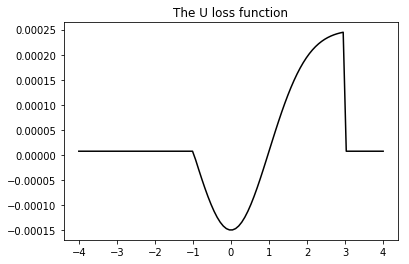

In [13]:
k = 100
x = np.linspace(-4,4,k)
m = 0 ; s = 1# np.ones(k)*.01 ; np.linspace(-1,1,k)
plt.title("The U loss function")
plt.plot(x,uloss(x,m,s), 'k-') ; plt.show()

## Backward functions

In [6]:
def dsoftmax(h, y, batch_size):
    h[range(batch_size),y] -= 1
    return h/y.shape[0] # divide by batch size

def drelu(dz, h):
    dz[h <= 0] = 0 # backprop relu
    return dz

def dxW_plus_b(dh, W):
    return np.dot(dh, W.T)

## Forward pass

In [7]:
def forward(X, model):
    # evaluate class scores, [N x K]
    hs = [] # we'll need the h's for computing gradients
    
    z1 = xW_plus_b(X, model['W1'], model['b1'])
    h1 = relu(z1) ; hs.append(h1)
    
    z2 = xW_plus_b(h1, model['W2'], model['b2'])
    h2 = relu(z2) ; hs.append(h2)
    
    z3 = xW_plus_b(h2, model['W3'], model['b3'])
    h3 = z3 ; hs.append(h3)
    
    probs = softmax(h3)
    
    return probs, hs

In [8]:
# evaluate test set accuracy
def test_accuracy(model):
    X = mnist.test.images
    y = mnist.test.labels
    scores, _ = forward(X, model)
    predicted_class = np.argmax(scores, axis=1)
    return (np.mean(predicted_class == y))

## Backward pass

In [9]:
def backward(y, probs, stats, X, hs, model):
    grads = { k : np.zeros_like(v) for k,v in model.items() }
    
    # third hidden layer
    dh3 = dsoftmax(probs, y, batch_size)
    
    grads['W3'] = np.dot(hs[-2].T, dh3)
    grads['b3'] = np.sum(dh3, axis=0, keepdims=True)
    
    # second hidden layer
    dh3 = uloss(hs[-1],stats['mus'][-1], stats['sigmas'][-1])
    
    dh2 = dxW_plus_b(dh3, model['W3']) #; print(dh2)
    dh2 = drelu(dh2, hs[-2]) # backprop through relu
    grads['W2'] = np.dot(hs[-3].T, dh2)
    grads['b2'] = np.sum(dh2, axis=0, keepdims=True)

    # first hidden layer
    dh2 = uloss(hs[-2],stats['mus'][-2], stats['sigmas'][-2])
    
    dh1 = dxW_plus_b(dh2, model['W2'])
    dh1 = drelu(dh1, hs[-3]) # backprop through relu
    grads['W1'] = np.dot(X.T, dh1)
    grads['b1'] = np.sum(dh1, axis=0, keepdims=True)
    return grads

## Train loop

In [10]:
# generic train loop
interp = 0.99
stats = {'mus':None, 'sigmas':None}
running_loss = None

for global_step in range(global_step, total_steps+global_step+1):
    
    # forward
    X, y = mnist.train.next_batch(batch_size)
    probs, hs = forward(X, model)
    
    y_logprobs = -np.log(probs[range(batch_size),y]) # cross-entropy loss
    loss = np.sum(y_logprobs)/batch_size
    
    # feedforward stats (keep running averages of each neuron's statistics over time)
    mus = [np.asarray(h) for h in hs]
    sigmas = [np.ones_like(v)*.001 for v in mus] if stats['mus'] is None else [np.abs(stats['mus'][i] - mus[i]) for i in range(len(mus))]
    stats['mus'] = mus if stats['mus'] is None else [interp*stats['mus'][i] + (1.-interp)*mus[i] for i in range(len(mus))]
    stats['sigmas'] = sigmas if stats['sigmas'] is None else [interp*stats['sigmas'][i] + (1.-interp)*sigmas[i] for i in range(len(sigmas))]
    
    running_loss = loss if running_loss is None else interp*running_loss + (1.-interp)*loss
    
    # backward
    grads = backward(y, probs, stats, X, hs, model) # data gradients
    model = {k : model[k] - lr*grads[k] for (k,v) in grads.items()} # update parameters

    # ======== DISPLAY PROGRESS ======== #
    if global_step % print_every == 0:
        if global_step / 4 % print_every == 0:
            print('accuracy: {:.2f}%'.format(100*test_accuracy(model)))
        print('\tstep {}: loss: {:.4f}'
              .format(global_step, running_loss))

accuracy: 10.56%
	step 0: loss: 3.6430
	step 500: loss: 2.9194
	step 1000: loss: 2.6196
	step 1500: loss: 2.4482
accuracy: 15.70%
	step 2000: loss: 2.3614
	step 2500: loss: 2.3150
	step 3000: loss: 2.2570
	step 3500: loss: 2.2015
accuracy: 21.51%
	step 4000: loss: 2.1697
	step 4500: loss: 2.1349
	step 5000: loss: 2.0903
	step 5500: loss: 2.0612
accuracy: 29.00%
	step 6000: loss: 2.0206
	step 6500: loss: 2.0034
	step 7000: loss: 1.9812
	step 7500: loss: 1.9357
accuracy: 34.78%
	step 8000: loss: 1.9341
	step 8500: loss: 1.9106
	step 9000: loss: 1.8904
	step 9500: loss: 1.8721
accuracy: 39.48%
	step 10000: loss: 1.8691
